In [3]:
import os
import urllib.request
import zipfile

def download_tiny_imagenet(data_dir='./data'):
    os.makedirs(data_dir, exist_ok=True)
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_path = os.path.join(data_dir, 'tiny-imagenet-200.zip')

    if not os.path.exists(os.path.join(data_dir, 'tiny-imagenet-200')):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        print("Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        os.remove(zip_path)
        print("Done!")
    else:
        print("Tiny ImageNet already downloaded.")

    return os.path.join(data_dir, 'tiny-imagenet-200')


### **Albumentations Transforms**

(https://github.com/albumentations-team/albumentations)

It defines train_tfms using A.Compose to chain together several augmentation techniques from albumentations.

It defines train_tfms using `A.Compose` to chain together several augmentation techniques from albumentations

1. `A.HorizontalFlip`: Randomly flips images horizontally.
2. `A.ShiftScaleRotate`: Applies random affine transformations (shifting, scaling, and rotating).
3. `A.CoarseDropout`: (this is **CutOut**) Randomly drops rectangular regions from the image and fills them with the calculated mean value.
4. `A.Normalize`: Normalizes the pixel values using the pre-computed `MEAN` and `STD`.
5. `ToTensorV2`: Converts the augmented image (which is a NumPy array at this point in the albumentations pipeline) into a PyTorch tensor and moves the channel dimension to the front (C, H, W).

`AlbuTinyImageNet` Dataset Class: It creates a custom Dataset class AlbuCIFAR that wraps the standard tiny imagenet dataset. T**his is necessary because albumentations works with NumPy arrays in HWC (Height, Width, Channel) format, while torchvision datasets return PIL Images (which are converted to tensors in C, H, W format by their default ToTensor)**. The __getitem__ method converts the PIL Image to a NumPy array before applying the albumentations transform.





In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os

# ImageNet normalization stats (standard for ImageNet-based datasets)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Convert to 0..255 for fill_value
fill_value_255 = tuple(int(m * 255) for m in MEAN)

def get_train_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
        A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
                        min_holes=1, min_height=int(image_size*0.25), min_width=int(image_size*0.25),
                        fill_value=fill_value_255, p=0.5),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

def get_val_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

class AlbuTinyImageNet(Dataset):
    def __init__(self, root, train=True, transform=None):
        split = 'train' if train else 'val'
        self.ds = datasets.ImageFolder(os.path.join(root, split))
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]  # PIL Image
        img = np.array(img)        # -> HWC uint8 RGB
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        return img, label


In [5]:
def get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2):
    """
    Create train and validation dataloaders for Tiny ImageNet

    Args:
        data_path: Path to tiny-imagenet-200 directory
        batch_size: Batch size for training
        image_size: Target image size (64 for now, 224 for later)
        num_workers: Number of worker processes
    """
    train_tfms = get_train_transforms(image_size)
    val_tfms = get_val_transforms(image_size)

    train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=train_tfms)
    val_ds = AlbuTinyImageNet(root=data_path, train=False, transform=val_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True,persistent_workers=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True,persistent_workers=True)

    return train_loader, val_loader


In [6]:
import os
import shutil

def reorganize_val_folder(data_path):
    """Reorganize Tiny ImageNet validation folder to work with ImageFolder"""
    val_dir = os.path.join(data_path, 'val')
    img_dir = os.path.join(val_dir, 'images')
    annotations_file = os.path.join(val_dir, 'val_annotations.txt')

    # Read annotations
    with open(annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_name = parts[0]
            class_id = parts[1]

            # Create class folder if it doesn't exist
            class_folder = os.path.join(val_dir, class_id)
            os.makedirs(class_folder, exist_ok=True)

            # Move image to class folder
            src = os.path.join(img_dir, img_name)
            dst = os.path.join(class_folder, img_name)
            if os.path.exists(src):
                shutil.move(src, dst)

    # Remove empty images folder
    if os.path.exists(img_dir) and not os.listdir(img_dir):
        os.rmdir(img_dir)

    print("Validation folder reorganized successfully!")

In [7]:
# Download data
data_path = download_tiny_imagenet()

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

Extracting...
Done!


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_37/1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


**Quick sanity check**

In [8]:
# Peek a batch and verify normalization stats roughly centered
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| dtype:", imgs.dtype, "| range ~", (imgs.min().item(), imgs.max().item()))
print("Per-channel mean (batch):", imgs.mean(dim=(0,2,3)))
print("Per-channel std  (batch):", imgs.std(dim=(0,2,3)))

Batch shape: torch.Size([128, 3, 64, 64]) | dtype: torch.float32 | range ~ (-2.1179039478302, 2.6399998664855957)
Per-channel mean (batch): tensor([-0.1128, -0.1770, -0.1756])
Per-channel std  (batch): tensor([1.2278, 1.2256, 1.2512])


**Helper: denormalize + show grid**

In [9]:
# Utils to denormalize and visualize a small grid of images
import math
import torch
import matplotlib.pyplot as plt

# Use MEAN/STD computed earlier (lists) and make tensors for broadcasting
_MEAN = torch.tensor(MEAN).view(1, 3, 1, 1)
_STD  = torch.tensor(STD).view(1, 3, 1, 1)

def denorm(imgs):
    """imgs: tensor [B,C,H,W] normalized with MEAN/STD -> return in [0,1]"""
    x = imgs.clone().cpu()
    x = x * _STD + _MEAN
    return x.clamp(0.0, 1.0)

def show_batch(images, labels, class_names, n=16, cols=8):
    """
    Show n images with titles (class names) in a grid.
    images: [B,C,H,W] tensor (normalized)
    labels: [B] tensor
    """
    n = min(n, images.size(0))
    rows = math.ceil(n / cols)
    imgs = denorm(images[:n])

    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i in range(n):
        img = imgs[i].permute(1, 2, 0).numpy()  # HWC
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(class_names[int(labels[i])], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


**View a random training batch (with augmentations)**

/tmp/ipykernel_37/1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


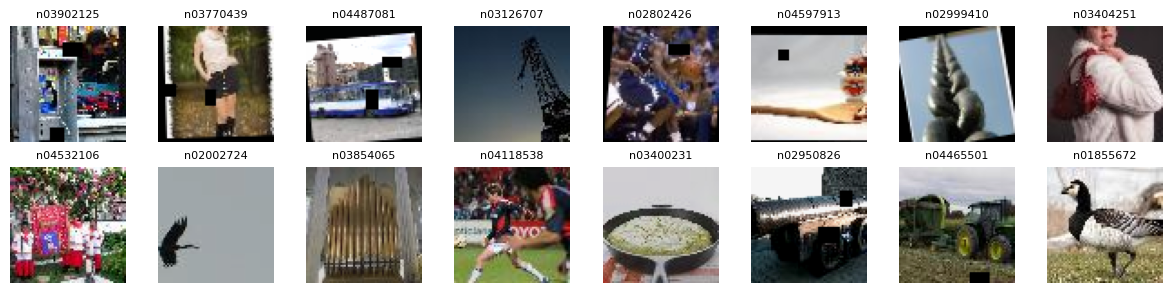

In [10]:
import matplotlib.pyplot as plt

train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=get_train_transforms(64))
class_names = train_ds.ds.classes


def show_batch(images, labels, class_names, n=16, cols=8):
    """Display a batch of images with their labels."""
    n = min(n, len(images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # CHW -> HWC
        img = img * np.array(STD) + np.array(MEAN)  # denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display batch
train_images, train_labels = next(iter(train_loader))
show_batch(train_images, train_labels, class_names, n=16, cols=8)


**View a random test batch (no augmentations)**

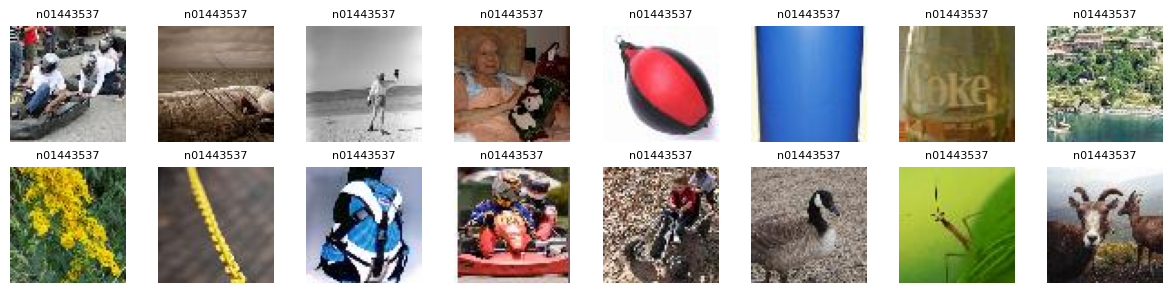

In [11]:
val_images, val_labels = next(iter(val_loader))
show_batch(val_images, val_labels, class_names, n=16, cols=8)

In [12]:
import numpy as np

def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [13]:
def cutmix_data(x, y, alpha=1.0, device='cuda'):
    '''Returns CutMix inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # Get random box
    W = x.size()[2]
    H = x.size()[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform sampling
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Apply cutmix
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


In [14]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}


In [15]:
import copy
import torch
import torch.nn.functional as F
from tqdm import tqdm

# keep your history lists (now store epoch-level stats)
train_losses, test_losses = [], []
train_acc,    test_acc    = [], []

class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-4, restore_best_weights=True, checkpoint_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.checkpoint_path = checkpoint_path
        self.best = float('inf')
        self.wait = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_state = copy.deepcopy(model.state_dict())
            if self.checkpoint_path:
                torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.wait += 1
        return self.wait >= self.patience

    def load_best(self, model):
        if self.restore_best_weights and self.best_state is not None:
            model.load_state_dict(self.best_state)
        elif self.checkpoint_path:
            model.load_state_dict(torch.load(self.checkpoint_path, map_location="cpu"))

# mix precision training loop with gradient clipping

from torch.cuda.amp import autocast, GradScaler

def train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2):
    model.train()
    pbar = tqdm(train_loader, desc=f"Train E{epoch:02d}")
    correct, total = 0, 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        # Apply mixup
        if np.random.random() > 0.5:
            data, targets_a, targets_b, lam = mixup_data(data, target, mixup_alpha, device)
        else:
            data, targets_a, targets_b, lam = cutmix_data(data, target, 1.0, device)

        optimizer.zero_grad()

        with autocast():
            y_pred = model(data)
            loss = mixup_criterion(
                lambda pred, y: F.cross_entropy(pred, y, label_smoothing=0.1),
                y_pred, targets_a, targets_b, lam
            )

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Update EMA
        # ema.update()

        # stats
        running_loss += loss.item() * data.size(0)
        pred = y_pred.argmax(dim=1)
        correct += (lam * pred.eq(targets_a).sum().float()
                    + (1 - lam) * pred.eq(targets_b).sum().float()).item()
        total += data.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    return epoch_loss, epoch_acc


def test(model, device, test_loader, epoch=None):
    model.eval()
    test_loss_sum, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum', label_smoothing=0.1)  # sum over batch
            test_loss_sum += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.size(0)

    avg_loss = test_loss_sum / total
    acc = 100.0 * correct / total
    test_losses.append(avg_loss)
    test_acc.append(acc)

    if epoch is not None:
        print(f"\nVal E{epoch:02d}: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")
    else:
        print(f"\nVal: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")

    return avg_loss, acc


### ResNet with ReLu with conv instead of fc

In [16]:
!pip install antialiased_cnns
import torch
import torch.nn as nn
import torch.nn.functional as F
import antialiased_cnns

class BasicBlock(nn.Module):
    """Original ResNet Basic Block"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)  # ReLU after addition!

        return out


class BottleneckBlock(nn.Module):
    """Original ResNet Bottleneck Block"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample

    def forward(self, x):
      identity = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = F.relu(out, inplace=True)

      out = self.conv2(out)  # <- Fixed: was self.conv2(x)
      out = self.bn2(out)
      out = F.relu(out, inplace=True)

      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample is not None:
          identity = self.downsample(x)

      out += identity
      out = F.relu(out, inplace=True)

      return out



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, use_blurpool=False):
        super().__init__()
        self.in_channels = 64
        self.use_blurpool = use_blurpool

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        #replace maxpool by MaxBlurPool
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        if self.use_blurpool:
            self.maxpool_or_blurpool = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1), antialiased_cnns.BlurPool(64, stride=2))
        else:
            self.maxpool_or_blurpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        #replace maxpool by MaxBlurPool
        # x = self.maxpool(x)
        x = self.maxpool_or_blurpool(x)
        # for layer in self.maxblurpool: # Apply layers sequentially
        #     x = layer(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = torch.flatten(x, 1)

        return x

# Factory functions

def resnet50_with_relu_conv(num_classes=1000, use_blurpool=False):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes, use_blurpool=use_blurpool)

In [18]:
# model = resnet50_with_relu(num_classes=200)
# model = resnet50(num_classes=200)
model = resnet50_with_relu_conv(num_classes=200, use_blurpool=True) # Set use_blurpool to True
# model = resnet50(num_classes=1000, drop_path_rate=0.2, use_blurpool=True) # Set use_blurpool to True

In [19]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = model.to(device)
summary(model, input_size=(3, 64, 64)) # Changed input size to match Tiny ImageNet size

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 30, 30]               0
   ReflectionPad2d-4           [-1, 64, 33, 33]               0
          BlurPool-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 64, 15, 15]           4,096
       BatchNorm2d-7           [-1, 64, 15, 15]             128
            Conv2d-8           [-1, 64, 15, 15]          36,864
       BatchNorm2d-9           [-1, 64, 15, 15]             128
           Conv2d-10          [-1, 256, 15, 15]          16,384
      BatchNorm2d-11          [-1, 256, 15, 15]             512
           Conv2d-12          [-1, 256, 15, 15]          16,384
      BatchNorm2d-13          [-1, 256, 15, 15]             512
  BottleneckBlock-14          [-1,

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import antialiased_cnns


def drop_path(x, drop_prob=0.0, training=False):
    """Drop paths (Stochastic Depth) per sample."""
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x.div(keep_prob) * random_tensor
    return output


class BasicBlock(nn.Module):
    """Original ResNet Basic Block with Stochastic Depth"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.drop_prob = drop_prob

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = drop_path(out, self.drop_prob, self.training)
        out += identity
        out = F.relu(out, inplace=True)

        return out


class BottleneckBlock(nn.Module):
    """Original ResNet Bottleneck Block with Stochastic Depth"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample
        self.drop_prob = drop_prob

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out, inplace=True)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = drop_path(out, self.drop_prob, self.training)
        out += identity
        out = F.relu(out, inplace=True)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, drop_path_rate=0.2, use_blurpool=False):
        super().__init__()
        self.in_channels = 64
        self.use_blurpool = use_blurpool

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        if self.use_blurpool:
            self.maxpool_or_blurpool = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1), antialiased_cnns.BlurPool(64, stride=2))
        else:
            self.maxpool_or_blurpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        # Calculate total number of blocks
        total_blocks = sum(layers)
        # Linear drop path rate schedule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]

        # Track current block index
        block_idx = 0

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1,
                                       drop_probs=dpr[block_idx:block_idx+layers[0]])
        block_idx += layers[0]

        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[1]])
        block_idx += layers[1]

        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[2]])
        block_idx += layers[2]

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[3]])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

    def _make_layer(self, block, out_channels, blocks, stride, drop_probs):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, drop_probs[0]))
        self.in_channels = out_channels * block.expansion

        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, drop_prob=drop_probs[i]))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)

        x = self.maxpool_or_blurpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = torch.flatten(x, 1)

        return x

def resnet50(num_classes=1000, drop_path_rate=0.2, use_blurpool=False):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes, drop_path_rate, use_blurpool)

### model & model summary

In [22]:
# model = resnet50_with_relu(num_classes=200)
# model = resnet50(num_classes=200)
# model = resnet50_with_relu_conv(num_classes=200)
model = resnet50(num_classes=1000, drop_path_rate=0.2)

In [23]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = model.to(device)
summary(model, input_size=(3, 64, 64)) # Changed input size to match Tiny ImageNet size

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           4,096
       BatchNorm2d-5           [-1, 64, 16, 16]             128
            Conv2d-6           [-1, 64, 16, 16]          36,864
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8          [-1, 256, 16, 16]          16,384
       BatchNorm2d-9          [-1, 256, 16, 16]             512
           Conv2d-10          [-1, 256, 16, 16]          16,384
      BatchNorm2d-11          [-1, 256, 16, 16]             512
  BottleneckBlock-12          [-1, 256, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          16,384
      BatchNorm2d-14           [-1

### Finding the learning rate for OneCylePolicy LR Scheduler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.18E-05


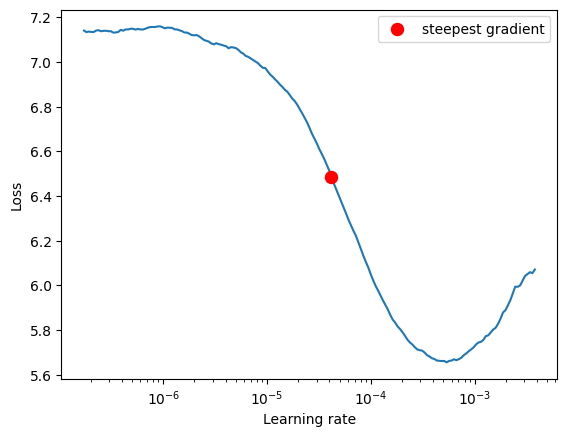

In [24]:
# Install if needed
!pip install torch-lr-finder

import torch.optim as optim
from torch_lr_finder import LRFinder

# Create fresh model and optimizer
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Run LR finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=0.005, num_iter=200)
lr_finder.plot()  # Shows the loss vs learning rate
lr_finder.reset()  # Reset model and optimizer

### **run it!! - reorganize validation files (important to run once)**

In [25]:
# Run it
reorganize_val_folder(data_path)

Validation folder reorganized successfully!


### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3

**Observation**: new high accuracy of ~ 50% was reached
tried running with EMA but accuracy was stuck at 0.5% maybe decay param is wrong

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200, use_blurpool=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

scaler = GradScaler()
# ema = EMA(model, decay=0.9999)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler)

    # Use EMA weights for validation
    # ema.apply_shadow()
    val_loss, val_acc = test(model, device, val_loader, epoch)
    # ema.restore()

    # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")

Device: cuda


/tmp/ipykernel_37/1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/tmp/ipykernel_37/470672021.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipykernel_37/188773879.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Train E01: 100%|██████████| 782/782 [01:04<00:00, 12.13it/s, acc=1.16%, loss=5.0601]



Val E01: loss=4.9658, acc=401/10000 (4.01%)



Train E02: 100%|██████████| 782/782 [01:03<00:00, 12.33it/s, acc=3.98%, loss=5.0249]



Val E02: loss=4.6490, acc=824/10000 (8.24%)



Train E03: 100%|██████████| 782/782 [01:03<00:00, 12.33it/s, acc=6.86%, loss=5.0459]



Val E03: loss=4.4515, acc=1269/10000 (12.69%)



Train E04: 100%|██████████| 782/782 [01:03<00:00, 12.32it/s, acc=9.42%, loss=4.6513]



Val E04: loss=4.2250, acc=1611/10000 (16.11%)



Train E05: 100%|██████████| 782/782 [01:03<00:00, 12.39it/s, acc=11.83%, loss=4.0343]



Val E05: loss=3.9580, acc=2038/10000 (20.38%)



Train E06: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, acc=13.25%, loss=3.8084]



Val E06: loss=3.9591, acc=2124/10000 (21.24%)



Train E07: 100%|██████████| 782/782 [01:03<00:00, 12.40it/s, acc=15.05%, loss=4.1730]



Val E07: loss=3.9121, acc=2226/10000 (22.26%)



Train E08: 100%|██████████| 782/782 [01:03<00:00, 12.36it/s, acc=16.04%, loss=4.4061]



Val E08: loss=4.1189, acc=2416/10000 (24.16%)



Train E09: 100%|██████████| 782/782 [01:03<00:00, 12.39it/s, acc=17.02%, loss=4.8669]



Val E09: loss=3.7244, acc=2619/10000 (26.19%)



Train E10: 100%|██████████| 782/782 [01:02<00:00, 12.42it/s, acc=17.90%, loss=4.1094]



Val E10: loss=3.7625, acc=2744/10000 (27.44%)



Train E11: 100%|██████████| 782/782 [01:02<00:00, 12.44it/s, acc=18.98%, loss=4.1140]



Val E11: loss=3.9778, acc=2675/10000 (26.75%)



Train E12: 100%|██████████| 782/782 [01:03<00:00, 12.28it/s, acc=19.84%, loss=4.6115]



Val E12: loss=3.6403, acc=2851/10000 (28.51%)



Train E13: 100%|██████████| 782/782 [01:02<00:00, 12.42it/s, acc=20.10%, loss=4.8824]



Val E13: loss=3.5869, acc=3088/10000 (30.88%)



Train E14: 100%|██████████| 782/782 [01:03<00:00, 12.23it/s, acc=20.97%, loss=4.3654]



Val E14: loss=3.4144, acc=3187/10000 (31.87%)



Train E15: 100%|██████████| 782/782 [01:04<00:00, 12.21it/s, acc=22.34%, loss=4.1652]



Val E15: loss=3.6794, acc=3023/10000 (30.23%)



Train E16: 100%|██████████| 782/782 [01:03<00:00, 12.32it/s, acc=22.73%, loss=4.4086]



Val E16: loss=3.3780, acc=3231/10000 (32.31%)



Train E17: 100%|██████████| 782/782 [01:03<00:00, 12.35it/s, acc=22.97%, loss=3.2107]



Val E17: loss=3.2211, acc=3567/10000 (35.67%)



Train E18: 100%|██████████| 782/782 [01:03<00:00, 12.23it/s, acc=24.43%, loss=3.1009]



Val E18: loss=3.2554, acc=3539/10000 (35.39%)



Train E19: 100%|██████████| 782/782 [01:04<00:00, 12.14it/s, acc=25.39%, loss=3.5651]



Val E19: loss=3.2291, acc=3501/10000 (35.01%)



Train E20: 100%|██████████| 782/782 [01:03<00:00, 12.30it/s, acc=25.87%, loss=4.4451]



Val E20: loss=3.1681, acc=3599/10000 (35.99%)



Train E21: 100%|██████████| 782/782 [01:04<00:00, 12.17it/s, acc=27.55%, loss=4.2364]



Val E21: loss=3.1266, acc=3782/10000 (37.82%)

✓ Saved best model at epoch 21 with accuracy: 37.82%


Train E22: 100%|██████████| 782/782 [01:04<00:00, 12.14it/s, acc=28.27%, loss=3.6678]



Val E22: loss=3.0760, acc=3943/10000 (39.43%)

✓ Saved best model at epoch 22 with accuracy: 39.43%


Train E23: 100%|██████████| 782/782 [01:03<00:00, 12.23it/s, acc=29.07%, loss=4.9218]



Val E23: loss=3.0875, acc=3884/10000 (38.84%)



Train E24: 100%|██████████| 782/782 [01:03<00:00, 12.27it/s, acc=29.38%, loss=3.2730]



Val E24: loss=3.0672, acc=3941/10000 (39.41%)



Train E25: 100%|██████████| 782/782 [01:03<00:00, 12.27it/s, acc=31.58%, loss=4.2950]



Val E25: loss=3.0168, acc=4102/10000 (41.02%)

✓ Saved best model at epoch 25 with accuracy: 41.02%


Train E26: 100%|██████████| 782/782 [01:03<00:00, 12.30it/s, acc=31.60%, loss=4.4964]



Val E26: loss=3.0545, acc=4000/10000 (40.00%)



Train E27: 100%|██████████| 782/782 [01:03<00:00, 12.40it/s, acc=33.82%, loss=2.9345]



Val E27: loss=3.0036, acc=4132/10000 (41.32%)

✓ Saved best model at epoch 27 with accuracy: 41.32%


Train E28: 100%|██████████| 782/782 [01:03<00:00, 12.38it/s, acc=33.76%, loss=4.2103]



Val E28: loss=3.0757, acc=4115/10000 (41.15%)



Train E29: 100%|██████████| 782/782 [01:03<00:00, 12.40it/s, acc=34.57%, loss=3.6018]



Val E29: loss=2.8564, acc=4495/10000 (44.95%)

✓ Saved best model at epoch 29 with accuracy: 44.95%


Train E30: 100%|██████████| 782/782 [01:02<00:00, 12.46it/s, acc=35.58%, loss=2.6135]



Val E30: loss=2.8554, acc=4480/10000 (44.80%)



Train E31: 100%|██████████| 782/782 [01:03<00:00, 12.29it/s, acc=36.58%, loss=3.3255]



Val E31: loss=2.8625, acc=4469/10000 (44.69%)



Train E32: 100%|██████████| 782/782 [01:04<00:00, 12.19it/s, acc=38.49%, loss=3.0265]



Val E32: loss=2.8033, acc=4644/10000 (46.44%)

✓ Saved best model at epoch 32 with accuracy: 46.44%


Train E33: 100%|██████████| 782/782 [01:04<00:00, 12.16it/s, acc=38.56%, loss=2.3787]



Val E33: loss=2.7817, acc=4672/10000 (46.72%)

✓ Saved best model at epoch 33 with accuracy: 46.72%


Train E34: 100%|██████████| 782/782 [01:04<00:00, 12.15it/s, acc=39.16%, loss=3.1593]



Val E34: loss=2.7500, acc=4781/10000 (47.81%)

✓ Saved best model at epoch 34 with accuracy: 47.81%


Train E35: 100%|██████████| 782/782 [01:03<00:00, 12.24it/s, acc=40.73%, loss=4.8470]



Val E35: loss=2.8108, acc=4596/10000 (45.96%)



Train E36: 100%|██████████| 782/782 [01:03<00:00, 12.30it/s, acc=41.78%, loss=4.1603]



Val E36: loss=2.7569, acc=4782/10000 (47.82%)

✓ Saved best model at epoch 36 with accuracy: 47.82%


Train E37: 100%|██████████| 782/782 [01:03<00:00, 12.27it/s, acc=42.11%, loss=4.7442]



Val E37: loss=2.7229, acc=4871/10000 (48.71%)

✓ Saved best model at epoch 37 with accuracy: 48.71%


Train E38: 100%|██████████| 782/782 [01:03<00:00, 12.24it/s, acc=43.03%, loss=5.3312]



Val E38: loss=2.7954, acc=4811/10000 (48.11%)



Train E39: 100%|██████████| 782/782 [01:03<00:00, 12.34it/s, acc=44.83%, loss=3.3380]



Val E39: loss=2.7215, acc=4903/10000 (49.03%)

✓ Saved best model at epoch 39 with accuracy: 49.03%


Train E40: 100%|██████████| 782/782 [01:03<00:00, 12.39it/s, acc=45.24%, loss=4.1214]



Val E40: loss=2.7224, acc=4882/10000 (48.82%)



Train E41: 100%|██████████| 782/782 [01:03<00:00, 12.38it/s, acc=47.23%, loss=3.5004]



Val E41: loss=2.6790, acc=4986/10000 (49.86%)

✓ Saved best model at epoch 41 with accuracy: 49.86%


Train E42: 100%|██████████| 782/782 [01:03<00:00, 12.35it/s, acc=46.21%, loss=3.9155]



Val E42: loss=2.6864, acc=4997/10000 (49.97%)

✓ Saved best model at epoch 42 with accuracy: 49.97%


Train E43: 100%|██████████| 782/782 [01:02<00:00, 12.48it/s, acc=47.31%, loss=4.3744]



Val E43: loss=2.7094, acc=4979/10000 (49.79%)



Train E44: 100%|██████████| 782/782 [01:03<00:00, 12.41it/s, acc=46.49%, loss=4.1631]



Val E44: loss=2.6999, acc=5031/10000 (50.31%)

✓ Saved best model at epoch 44 with accuracy: 50.31%


Train E45: 100%|██████████| 782/782 [01:02<00:00, 12.50it/s, acc=49.76%, loss=2.5006]



Val E45: loss=2.7049, acc=5023/10000 (50.23%)



Train E46: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, acc=50.25%, loss=2.9682]



Val E46: loss=2.7015, acc=5018/10000 (50.18%)



Train E47: 100%|██████████| 782/782 [01:02<00:00, 12.51it/s, acc=50.85%, loss=5.9321]



Val E47: loss=2.7061, acc=5011/10000 (50.11%)



Train E48: 100%|██████████| 782/782 [01:02<00:00, 12.47it/s, acc=51.79%, loss=4.1386]



Val E48: loss=2.7039, acc=5002/10000 (50.02%)



Train E49: 100%|██████████| 782/782 [01:02<00:00, 12.44it/s, acc=51.36%, loss=3.9321]



Val E49: loss=2.7171, acc=4977/10000 (49.77%)



Train E50: 100%|██████████| 782/782 [01:02<00:00, 12.52it/s, acc=52.34%, loss=1.9801]



Val E50: loss=2.7354, acc=4995/10000 (49.95%)



Train E51: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, acc=53.19%, loss=1.6558]



Val E51: loss=2.7055, acc=5041/10000 (50.41%)

✓ Saved best model at epoch 51 with accuracy: 50.41%


Train E52: 100%|██████████| 782/782 [01:02<00:00, 12.48it/s, acc=53.36%, loss=2.1063]



Val E52: loss=2.7102, acc=4959/10000 (49.59%)



Train E53: 100%|██████████| 782/782 [01:02<00:00, 12.49it/s, acc=53.95%, loss=3.0026]



Val E53: loss=2.7072, acc=4999/10000 (49.99%)



Train E54: 100%|██████████| 782/782 [01:02<00:00, 12.59it/s, acc=55.59%, loss=2.0714]



Val E54: loss=2.6787, acc=5122/10000 (51.22%)

✓ Saved best model at epoch 54 with accuracy: 51.22%


Train E55: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s, acc=55.24%, loss=2.1437]



Val E55: loss=2.6869, acc=5108/10000 (51.08%)



Train E56: 100%|██████████| 782/782 [01:02<00:00, 12.47it/s, acc=55.45%, loss=4.1890]



Val E56: loss=2.6782, acc=5130/10000 (51.30%)

✓ Saved best model at epoch 56 with accuracy: 51.30%


Train E57: 100%|██████████| 782/782 [01:02<00:00, 12.49it/s, acc=57.42%, loss=8.8203]



Val E57: loss=2.6755, acc=5116/10000 (51.16%)



Train E58: 100%|██████████| 782/782 [01:02<00:00, 12.49it/s, acc=58.10%, loss=2.5444]



Val E58: loss=2.6697, acc=5130/10000 (51.30%)



Train E59: 100%|██████████| 782/782 [01:02<00:00, 12.43it/s, acc=58.68%, loss=3.9776]



Val E59: loss=2.7068, acc=5085/10000 (50.85%)



Train E60: 100%|██████████| 782/782 [01:02<00:00, 12.51it/s, acc=57.77%, loss=3.2028]



Val E60: loss=2.6862, acc=5136/10000 (51.36%)

✓ Saved best model at epoch 60 with accuracy: 51.36%


Train E61: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, acc=58.90%, loss=4.3219]



Val E61: loss=2.7014, acc=5121/10000 (51.21%)



Train E62: 100%|██████████| 782/782 [01:02<00:00, 12.46it/s, acc=59.21%, loss=3.5615]



Val E62: loss=2.6770, acc=5194/10000 (51.94%)

✓ Saved best model at epoch 62 with accuracy: 51.94%


Train E63: 100%|██████████| 782/782 [01:02<00:00, 12.48it/s, acc=61.25%, loss=1.8101]



Val E63: loss=2.6681, acc=5205/10000 (52.05%)

✓ Saved best model at epoch 63 with accuracy: 52.05%


Train E64:  96%|█████████▌| 751/782 [01:00<00:02, 12.52it/s, acc=60.44%, loss=2.3823]

### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing**

**Observation**: new high accuracy of ~ 56% was reached
very good overall acceleration of occuracy

In [ ]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 30:
        return 64
    elif epoch <= 60:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=2)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/tmp/ipython-input-2361971846.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Switching to image size: 64x64



Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-1270004529.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Train E01: 100%|██████████| 782/782 [01:35<00:00,  8.16it/s, acc=1.78%, loss=4.9914]



Val E01: loss=4.9357, acc=474/10000 (4.74%)



Train E02: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s, acc=6.14%, loss=4.5370]



Val E02: loss=4.5381, acc=945/10000 (9.45%)



Train E03: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s, acc=10.24%, loss=5.0524]



Val E03: loss=4.2453, acc=1495/10000 (14.95%)



Train E04: 100%|██████████| 782/782 [01:34<00:00,  8.26it/s, acc=13.59%, loss=4.7358]



Val E04: loss=4.0904, acc=1705/10000 (17.05%)



Train E05: 100%|██████████| 782/782 [01:33<00:00,  8.37it/s, acc=16.65%, loss=4.2095]



Val E05: loss=4.0440, acc=1956/10000 (19.56%)



Train E06: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s, acc=19.58%, loss=4.6822]



Val E06: loss=3.7899, acc=2336/10000 (23.36%)



Train E07: 100%|██████████| 782/782 [01:33<00:00,  8.34it/s, acc=21.29%, loss=3.9575]



Val E07: loss=3.7203, acc=2510/10000 (25.10%)



Train E08: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=23.49%, loss=4.7166]



Val E08: loss=3.6507, acc=2644/10000 (26.44%)



Train E09: 100%|██████████| 782/782 [01:33<00:00,  8.37it/s, acc=25.27%, loss=3.6032]



Val E09: loss=3.8587, acc=2709/10000 (27.09%)



Train E10: 100%|██████████| 782/782 [01:32<00:00,  8.45it/s, acc=26.49%, loss=3.2856]



Val E10: loss=3.6307, acc=2792/10000 (27.92%)



Train E11: 100%|██████████| 782/782 [01:33<00:00,  8.39it/s, acc=28.58%, loss=3.5103]



Val E11: loss=3.3839, acc=3214/10000 (32.14%)



Train E12: 100%|██████████| 782/782 [01:32<00:00,  8.46it/s, acc=29.83%, loss=3.0541]



Val E12: loss=3.8354, acc=3303/10000 (33.03%)



Train E13: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s, acc=31.40%, loss=3.0492]



Val E13: loss=3.6466, acc=3049/10000 (30.49%)



Train E14: 100%|██████████| 782/782 [01:33<00:00,  8.38it/s, acc=32.84%, loss=3.5893]



Val E14: loss=3.8961, acc=3027/10000 (30.27%)



Train E15: 100%|██████████| 782/782 [01:32<00:00,  8.49it/s, acc=34.87%, loss=2.9388]



Val E15: loss=3.2396, acc=3591/10000 (35.91%)



Train E16: 100%|██████████| 782/782 [01:32<00:00,  8.47it/s, acc=37.32%, loss=2.9533]



Val E16: loss=3.0999, acc=3888/10000 (38.88%)



Train E17: 100%|██████████| 782/782 [01:32<00:00,  8.50it/s, acc=38.73%, loss=4.1146]



Val E17: loss=3.2822, acc=3772/10000 (37.72%)



Train E18: 100%|██████████| 782/782 [01:32<00:00,  8.43it/s, acc=39.89%, loss=4.4705]



Val E18: loss=3.0868, acc=4006/10000 (40.06%)



Train E19: 100%|██████████| 782/782 [01:32<00:00,  8.46it/s, acc=42.71%, loss=3.1615]



Val E19: loss=3.1589, acc=3960/10000 (39.60%)



Train E20: 100%|██████████| 782/782 [01:33<00:00,  8.39it/s, acc=43.92%, loss=3.2167]



Val E20: loss=3.1298, acc=3887/10000 (38.87%)



Train E21: 100%|██████████| 782/782 [01:31<00:00,  8.53it/s, acc=45.52%, loss=3.1258]



Val E21: loss=3.0027, acc=4203/10000 (42.03%)

✓ Saved best model at epoch 21 with accuracy: 42.03%


Train E22: 100%|██████████| 782/782 [01:31<00:00,  8.56it/s, acc=47.03%, loss=2.4981]



Val E22: loss=2.9695, acc=4290/10000 (42.90%)

✓ Saved best model at epoch 22 with accuracy: 42.90%


Train E23: 100%|██████████| 782/782 [01:30<00:00,  8.63it/s, acc=49.51%, loss=3.2843]



Val E23: loss=3.0129, acc=4248/10000 (42.48%)



Train E24: 100%|██████████| 782/782 [01:31<00:00,  8.54it/s, acc=50.86%, loss=2.5198]



Val E24: loss=3.0070, acc=4248/10000 (42.48%)



Train E25: 100%|██████████| 782/782 [01:30<00:00,  8.60it/s, acc=54.25%, loss=2.3952]



Val E25: loss=3.0492, acc=4224/10000 (42.24%)



Train E26: 100%|██████████| 782/782 [01:31<00:00,  8.58it/s, acc=56.96%, loss=3.0198]



Val E26: loss=3.0269, acc=4341/10000 (43.41%)

✓ Saved best model at epoch 26 with accuracy: 43.41%


Train E27: 100%|██████████| 782/782 [01:31<00:00,  8.55it/s, acc=58.92%, loss=2.6530]



Val E27: loss=3.0337, acc=4270/10000 (42.70%)



Train E28: 100%|██████████| 782/782 [01:32<00:00,  8.49it/s, acc=60.62%, loss=2.5397]



Val E28: loss=3.0718, acc=4298/10000 (42.98%)



Train E29: 100%|██████████| 782/782 [01:31<00:00,  8.59it/s, acc=63.54%, loss=2.8006]



Val E29: loss=3.1172, acc=4318/10000 (43.18%)



Train E30: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s, acc=64.79%, loss=2.4096]



Val E30: loss=3.1295, acc=4266/10000 (42.66%)


Switching to image size: 128x128



Train E31: 100%|██████████| 1563/1563 [02:49<00:00,  9.24it/s, acc=38.85%, loss=3.3065]



Val E31: loss=2.8530, acc=4556/10000 (45.56%)

✓ Saved best model at epoch 31 with accuracy: 45.56%


Train E32: 100%|██████████| 1563/1563 [02:47<00:00,  9.31it/s, acc=45.83%, loss=3.3957]



Val E32: loss=2.7062, acc=4917/10000 (49.17%)

✓ Saved best model at epoch 32 with accuracy: 49.17%


Train E33: 100%|██████████| 1563/1563 [02:46<00:00,  9.37it/s, acc=49.97%, loss=2.0430]



Val E33: loss=2.6046, acc=5135/10000 (51.35%)

✓ Saved best model at epoch 33 with accuracy: 51.35%


Train E34: 100%|██████████| 1563/1563 [02:48<00:00,  9.29it/s, acc=53.53%, loss=2.0983]



Val E34: loss=2.6308, acc=5147/10000 (51.47%)

✓ Saved best model at epoch 34 with accuracy: 51.47%


Train E35: 100%|██████████| 1563/1563 [02:47<00:00,  9.32it/s, acc=57.77%, loss=1.7352]



Val E35: loss=2.5587, acc=5331/10000 (53.31%)

✓ Saved best model at epoch 35 with accuracy: 53.31%


Train E36: 100%|██████████| 1563/1563 [02:48<00:00,  9.28it/s, acc=60.32%, loss=2.0641]



Val E36: loss=2.5113, acc=5517/10000 (55.17%)

✓ Saved best model at epoch 36 with accuracy: 55.17%


Train E37: 100%|██████████| 1563/1563 [02:48<00:00,  9.27it/s, acc=63.62%, loss=4.1278]



Val E37: loss=2.4874, acc=5583/10000 (55.83%)

✓ Saved best model at epoch 37 with accuracy: 55.83%


Train E38: 100%|██████████| 1563/1563 [02:47<00:00,  9.31it/s, acc=66.40%, loss=3.8107]



Val E38: loss=2.5058, acc=5522/10000 (55.22%)



Train E39: 100%|██████████| 1563/1563 [02:46<00:00,  9.38it/s, acc=70.04%, loss=1.7525]



Val E39: loss=2.4857, acc=5656/10000 (56.56%)

✓ Saved best model at epoch 39 with accuracy: 56.56%


Train E40: 100%|██████████| 1563/1563 [02:47<00:00,  9.31it/s, acc=71.41%, loss=1.5872]



Val E40: loss=2.5018, acc=5656/10000 (56.56%)



Train E41: 100%|██████████| 1563/1563 [02:47<00:00,  9.31it/s, acc=73.71%, loss=1.6861]



Val E41: loss=2.5027, acc=5686/10000 (56.86%)

✓ Saved best model at epoch 41 with accuracy: 56.86%


Train E42: 100%|██████████| 1563/1563 [02:47<00:00,  9.31it/s, acc=76.39%, loss=1.9201]



Val E42: loss=2.4918, acc=5650/10000 (56.50%)



Train E43: 100%|██████████| 1563/1563 [02:47<00:00,  9.33it/s, acc=77.43%, loss=1.2481]



Val E43: loss=2.5062, acc=5613/10000 (56.13%)



Train E44:  84%|████████▍ | 1313/1563 [02:20<00:26,  9.32it/s, acc=78.46%, loss=1.9453]


KeyboardInterrupt: 

### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing** + **CutMix along with MixUp** - progressive batch sizing interval was changed slightly

**Observation**: new high accuracy of ~ 67% was reached
**Progressive Batch Size Resizing** + **CutMix along with MixUp** had good overall impact however, some gap b/w train and test at the end of ~60 Epoch, more than ~3 hrs run


In [ ]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 25:
        return 64
    elif epoch <= 40:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=2)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




Device: cuda


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/tmp/ipython-input-2361971846.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Switching to image size: 64x64



Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-542621200.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Train E01: 100%|██████████| 782/782 [01:34<00:00,  8.28it/s, acc=1.45%, loss=5.0004]



Val E01: loss=4.9561, acc=409/10000 (4.09%)



Train E02: 100%|██████████| 782/782 [01:35<00:00,  8.17it/s, acc=4.65%, loss=4.5428]



Val E02: loss=4.5888, acc=944/10000 (9.44%)



Train E03: 100%|██████████| 782/782 [01:32<00:00,  8.45it/s, acc=7.75%, loss=5.1793]



Val E03: loss=4.3704, acc=1399/10000 (13.99%)



Train E04: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=10.67%, loss=4.7744]



Val E04: loss=4.1168, acc=1823/10000 (18.23%)



Train E05: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=12.80%, loss=4.4981]



Val E05: loss=4.5306, acc=1936/10000 (19.36%)



Train E06: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=14.19%, loss=5.0314]



Val E06: loss=4.2228, acc=2271/10000 (22.71%)



Train E07: 100%|██████████| 782/782 [01:32<00:00,  8.46it/s, acc=15.92%, loss=3.9361]



Val E07: loss=3.7349, acc=2360/10000 (23.60%)



Train E08: 100%|██████████| 782/782 [01:32<00:00,  8.47it/s, acc=17.64%, loss=4.1776]



Val E08: loss=4.1855, acc=2404/10000 (24.04%)



Train E09: 100%|██████████| 782/782 [01:32<00:00,  8.49it/s, acc=18.01%, loss=5.1123]



Val E09: loss=3.6380, acc=2696/10000 (26.96%)



Train E10: 100%|██████████| 782/782 [01:33<00:00,  8.37it/s, acc=18.82%, loss=4.0603]



Val E10: loss=3.7122, acc=2785/10000 (27.85%)



Train E11: 100%|██████████| 782/782 [01:33<00:00,  8.38it/s, acc=20.47%, loss=4.0079]



Val E11: loss=3.5685, acc=2885/10000 (28.85%)



Train E12: 100%|██████████| 782/782 [01:33<00:00,  8.34it/s, acc=21.53%, loss=4.6256]



Val E12: loss=3.5680, acc=2967/10000 (29.67%)



Train E13: 100%|██████████| 782/782 [01:34<00:00,  8.27it/s, acc=22.36%, loss=4.2897]



Val E13: loss=3.7247, acc=3127/10000 (31.27%)



Train E14: 100%|██████████| 782/782 [01:33<00:00,  8.37it/s, acc=24.27%, loss=4.0402]



Val E14: loss=3.3677, acc=3295/10000 (32.95%)



Train E15: 100%|██████████| 782/782 [01:33<00:00,  8.33it/s, acc=25.21%, loss=4.2244]



Val E15: loss=3.3349, acc=3460/10000 (34.60%)



Train E16: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s, acc=25.37%, loss=3.5209]



Val E16: loss=3.2598, acc=3588/10000 (35.88%)



Train E17: 100%|██████████| 782/782 [01:32<00:00,  8.49it/s, acc=27.01%, loss=2.9498]



Val E17: loss=3.3206, acc=3682/10000 (36.82%)



Train E18: 100%|██████████| 782/782 [01:31<00:00,  8.51it/s, acc=29.82%, loss=3.7478]



Val E18: loss=3.1452, acc=3855/10000 (38.55%)



Train E19: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=29.03%, loss=5.0864]



Val E19: loss=3.1902, acc=3766/10000 (37.66%)



Train E20: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=29.94%, loss=3.5927]



Val E20: loss=3.1526, acc=3935/10000 (39.35%)



Train E21: 100%|██████████| 782/782 [01:32<00:00,  8.47it/s, acc=31.52%, loss=3.1275]



Val E21: loss=3.0754, acc=4079/10000 (40.79%)

✓ Saved best model at epoch 21 with accuracy: 40.79%


Train E22: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=32.58%, loss=4.4044]



Val E22: loss=3.1284, acc=3903/10000 (39.03%)



Train E23: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=33.61%, loss=4.4414]



Val E23: loss=2.9936, acc=4175/10000 (41.75%)

✓ Saved best model at epoch 23 with accuracy: 41.75%


Train E24: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s, acc=34.60%, loss=4.2901]



Val E24: loss=2.9654, acc=4425/10000 (44.25%)

✓ Saved best model at epoch 24 with accuracy: 44.25%


Train E25: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s, acc=36.19%, loss=4.7100]



Val E25: loss=3.2586, acc=4341/10000 (43.41%)


Switching to image size: 128x128



Train E26: 100%|██████████| 1563/1563 [02:50<00:00,  9.15it/s, acc=29.23%, loss=4.2115]



Val E26: loss=2.9317, acc=4282/10000 (42.82%)



Train E27: 100%|██████████| 1563/1563 [02:50<00:00,  9.17it/s, acc=33.77%, loss=3.4148]



Val E27: loss=2.8410, acc=4505/10000 (45.05%)

✓ Saved best model at epoch 27 with accuracy: 45.05%


Train E28: 100%|██████████| 1563/1563 [02:49<00:00,  9.20it/s, acc=36.49%, loss=2.3970]



Val E28: loss=2.7046, acc=4843/10000 (48.43%)

✓ Saved best model at epoch 28 with accuracy: 48.43%


Train E29: 100%|██████████| 1563/1563 [02:50<00:00,  9.18it/s, acc=39.44%, loss=4.0001]



Val E29: loss=2.6080, acc=5119/10000 (51.19%)

✓ Saved best model at epoch 29 with accuracy: 51.19%


Train E30: 100%|██████████| 1563/1563 [02:47<00:00,  9.33it/s, acc=41.47%, loss=2.8129]



Val E30: loss=2.5720, acc=5180/10000 (51.80%)

✓ Saved best model at epoch 30 with accuracy: 51.80%


Train E31: 100%|██████████| 1563/1563 [02:48<00:00,  9.30it/s, acc=43.69%, loss=2.6517]



Val E31: loss=2.5140, acc=5402/10000 (54.02%)

✓ Saved best model at epoch 31 with accuracy: 54.02%


Train E32: 100%|██████████| 1563/1563 [02:48<00:00,  9.29it/s, acc=45.65%, loss=3.7518]



Val E32: loss=2.4720, acc=5490/10000 (54.90%)

✓ Saved best model at epoch 32 with accuracy: 54.90%


Train E33: 100%|██████████| 1563/1563 [02:47<00:00,  9.33it/s, acc=46.83%, loss=3.4032]



Val E33: loss=2.4158, acc=5706/10000 (57.06%)

✓ Saved best model at epoch 33 with accuracy: 57.06%


Train E34: 100%|██████████| 1563/1563 [02:47<00:00,  9.32it/s, acc=49.10%, loss=3.6600]



Val E34: loss=2.4249, acc=5640/10000 (56.40%)



Train E35: 100%|██████████| 1563/1563 [02:47<00:00,  9.34it/s, acc=51.24%, loss=1.8939]



Val E35: loss=2.3662, acc=5805/10000 (58.05%)

✓ Saved best model at epoch 35 with accuracy: 58.05%


Train E36: 100%|██████████| 1563/1563 [02:47<00:00,  9.32it/s, acc=52.28%, loss=3.1718]



Val E36: loss=2.3865, acc=5814/10000 (58.14%)

✓ Saved best model at epoch 36 with accuracy: 58.14%


Train E37: 100%|██████████| 1563/1563 [02:47<00:00,  9.32it/s, acc=54.07%, loss=2.2028]



Val E37: loss=2.3493, acc=5903/10000 (59.03%)

✓ Saved best model at epoch 37 with accuracy: 59.03%


Train E38: 100%|██████████| 1563/1563 [02:48<00:00,  9.28it/s, acc=55.77%, loss=4.2984]



Val E38: loss=2.3647, acc=5951/10000 (59.51%)

✓ Saved best model at epoch 38 with accuracy: 59.51%


Train E39: 100%|██████████| 1563/1563 [02:47<00:00,  9.32it/s, acc=58.26%, loss=3.8582]



Val E39: loss=2.3329, acc=5990/10000 (59.90%)

✓ Saved best model at epoch 39 with accuracy: 59.90%


Train E40: 100%|██████████| 1563/1563 [02:47<00:00,  9.32it/s, acc=58.79%, loss=3.4358]



Val E40: loss=2.3258, acc=6032/10000 (60.32%)

✓ Saved best model at epoch 40 with accuracy: 60.32%

Switching to image size: 224x224



Train E41: 100%|██████████| 1563/1563 [06:38<00:00,  3.92it/s, acc=50.20%, loss=3.5352]



Val E41: loss=2.2742, acc=6034/10000 (60.34%)

✓ Saved best model at epoch 41 with accuracy: 60.34%


Train E42: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=55.61%, loss=1.8329]



Val E42: loss=2.2539, acc=6181/10000 (61.81%)

✓ Saved best model at epoch 42 with accuracy: 61.81%


Train E43: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=56.63%, loss=1.6678]



Val E43: loss=2.2220, acc=6235/10000 (62.35%)

✓ Saved best model at epoch 43 with accuracy: 62.35%


Train E44: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=59.17%, loss=2.0708]



Val E44: loss=2.2183, acc=6253/10000 (62.53%)

✓ Saved best model at epoch 44 with accuracy: 62.53%


Train E45: 100%|██████████| 1563/1563 [06:38<00:00,  3.93it/s, acc=62.30%, loss=3.5559]



Val E45: loss=2.1911, acc=6393/10000 (63.93%)

✓ Saved best model at epoch 45 with accuracy: 63.93%


Train E46: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=62.24%, loss=1.7851]



Val E46: loss=2.1791, acc=6335/10000 (63.35%)



Train E47: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=64.87%, loss=1.7712]



Val E47: loss=2.1644, acc=6456/10000 (64.56%)

✓ Saved best model at epoch 47 with accuracy: 64.56%


Train E48: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=65.43%, loss=2.7327]



Val E48: loss=2.1556, acc=6495/10000 (64.95%)

✓ Saved best model at epoch 48 with accuracy: 64.95%


Train E49: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=67.23%, loss=3.7273]



Val E49: loss=2.1467, acc=6534/10000 (65.34%)

✓ Saved best model at epoch 49 with accuracy: 65.34%


Train E50: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=67.55%, loss=1.5262]



Val E50: loss=2.1240, acc=6586/10000 (65.86%)

✓ Saved best model at epoch 50 with accuracy: 65.86%


Train E51: 100%|██████████| 1563/1563 [06:38<00:00,  3.93it/s, acc=69.10%, loss=2.7092]



Val E51: loss=2.1123, acc=6575/10000 (65.75%)



Train E52: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=68.82%, loss=1.6221]



Val E52: loss=2.1217, acc=6585/10000 (65.85%)



Train E53: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=69.81%, loss=3.1768]



Val E53: loss=2.1180, acc=6650/10000 (66.50%)

✓ Saved best model at epoch 53 with accuracy: 66.50%


Train E54: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=71.31%, loss=2.4932]



Val E54: loss=2.1097, acc=6653/10000 (66.53%)

✓ Saved best model at epoch 54 with accuracy: 66.53%


Train E55: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=70.75%, loss=1.1874]



Val E55: loss=2.1007, acc=6713/10000 (67.13%)

✓ Saved best model at epoch 55 with accuracy: 67.13%


Train E56: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=72.37%, loss=1.0831]



Val E56: loss=2.0856, acc=6715/10000 (67.15%)

✓ Saved best model at epoch 56 with accuracy: 67.15%


Train E57: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=73.31%, loss=3.7934]



Val E57: loss=2.1148, acc=6695/10000 (66.95%)



Train E58: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=73.55%, loss=1.5998]



Val E58: loss=2.1039, acc=6743/10000 (67.43%)

✓ Saved best model at epoch 58 with accuracy: 67.43%


Train E59: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=72.23%, loss=1.9884]



Val E59: loss=2.0962, acc=6710/10000 (67.10%)



Train E60: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=73.85%, loss=2.7917]



Val E60: loss=2.1101, acc=6703/10000 (67.03%)



Train E61: 100%|██████████| 1563/1563 [06:37<00:00,  3.93it/s, acc=73.05%, loss=2.8266]



Val E61: loss=2.1134, acc=6701/10000 (67.01%)



Train E62:  32%|███▏      | 507/1563 [02:09<04:30,  3.91it/s, acc=72.47%, loss=1.3176]


KeyboardInterrupt: 

### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing** + **CutMix along with MixUp** + **Stochastic Depth**

**Observation**: same accuracy of ~ 67% was reached
**Stochastic Depth**caused the diff b/w test and train to reduce drastically, maybe continued training might have led to better results or additional lr tuning

In [ ]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 25:
        return 64
    elif epoch <= 50:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# # Create dataloaders (Tiny ImageNet has 200 classes)
# train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50(num_classes=200,drop_path_rate=0.2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=4)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




Device: cuda


/tmp/ipython-input-1762265193.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),



Switching to image size: 64x64



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-542621200.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch s


Val E01: loss=5.0635, acc=278/10000 (2.78%)



Train E02: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s, acc=3.60%, loss=5.0557]



Val E02: loss=4.6621, acc=769/10000 (7.69%)



Train E03: 100%|██████████| 782/782 [01:30<00:00,  8.62it/s, acc=6.38%, loss=4.7397]



Val E03: loss=4.4424, acc=1155/10000 (11.55%)



Train E04: 100%|██████████| 782/782 [01:31<00:00,  8.58it/s, acc=8.78%, loss=4.8367]



Val E04: loss=4.2021, acc=1556/10000 (15.56%)



Train E05: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s, acc=10.92%, loss=4.0949]



Val E05: loss=4.0085, acc=1941/10000 (19.41%)



Train E06: 100%|██████████| 782/782 [01:30<00:00,  8.62it/s, acc=13.04%, loss=4.9582]



Val E06: loss=4.0217, acc=2076/10000 (20.76%)



Train E07: 100%|██████████| 782/782 [01:30<00:00,  8.62it/s, acc=14.15%, loss=4.1343]



Val E07: loss=3.7924, acc=2359/10000 (23.59%)



Train E08: 100%|██████████| 782/782 [01:30<00:00,  8.63it/s, acc=14.87%, loss=3.8771]



Val E08: loss=3.8155, acc=2333/10000 (23.33%)



Train E09: 100%|██████████| 782/782 [01:30<00:00,  8.66it/s, acc=17.01%, loss=4.5526]



Val E09: loss=3.6324, acc=2586/10000 (25.86%)



Train E10: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s, acc=18.02%, loss=3.7275]



Val E10: loss=3.5844, acc=2754/10000 (27.54%)



Train E11: 100%|██████████| 782/782 [01:31<00:00,  8.53it/s, acc=18.88%, loss=3.7779]



Val E11: loss=3.6002, acc=2815/10000 (28.15%)



Train E12: 100%|██████████| 782/782 [01:29<00:00,  8.71it/s, acc=19.15%, loss=4.7076]



Val E12: loss=3.5298, acc=2847/10000 (28.47%)



Train E13: 100%|██████████| 782/782 [01:31<00:00,  8.56it/s, acc=20.27%, loss=4.9318]



Val E13: loss=3.6348, acc=2815/10000 (28.15%)



Train E14: 100%|██████████| 782/782 [01:31<00:00,  8.58it/s, acc=21.18%, loss=3.8278]



Val E14: loss=3.3812, acc=3222/10000 (32.22%)



Train E15: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s, acc=22.33%, loss=3.2708]



Val E15: loss=3.5183, acc=3237/10000 (32.37%)



Train E16: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s, acc=23.32%, loss=4.2867]



Val E16: loss=3.3754, acc=3210/10000 (32.10%)



Train E17: 100%|██████████| 782/782 [01:30<00:00,  8.59it/s, acc=23.89%, loss=4.7361]



Val E17: loss=3.2436, acc=3559/10000 (35.59%)



Train E18: 100%|██████████| 782/782 [01:30<00:00,  8.65it/s, acc=24.85%, loss=3.8689]



Val E18: loss=3.3189, acc=3334/10000 (33.34%)



Train E19: 100%|██████████| 782/782 [01:30<00:00,  8.62it/s, acc=25.90%, loss=4.4984]



Val E19: loss=3.2651, acc=3532/10000 (35.32%)



Train E20: 100%|██████████| 782/782 [01:31<00:00,  8.57it/s, acc=25.40%, loss=4.3860]



Val E20: loss=3.1520, acc=3749/10000 (37.49%)



Train E21: 100%|██████████| 782/782 [01:30<00:00,  8.66it/s, acc=27.38%, loss=3.0521]



Val E21: loss=3.1082, acc=3910/10000 (39.10%)

✓ Saved best model at epoch 21 with accuracy: 39.10%


Train E22: 100%|██████████| 782/782 [01:31<00:00,  8.58it/s, acc=28.47%, loss=4.4982]



Val E22: loss=3.0955, acc=3951/10000 (39.51%)

✓ Saved best model at epoch 22 with accuracy: 39.51%


Train E23: 100%|██████████| 782/782 [01:31<00:00,  8.57it/s, acc=28.80%, loss=2.7155]



Val E23: loss=3.0830, acc=3920/10000 (39.20%)



Train E24: 100%|██████████| 782/782 [01:31<00:00,  8.54it/s, acc=30.00%, loss=3.7255]



Val E24: loss=3.0576, acc=3957/10000 (39.57%)

✓ Saved best model at epoch 24 with accuracy: 39.57%


Train E25: 100%|██████████| 782/782 [01:31<00:00,  8.57it/s, acc=30.15%, loss=4.3243]



Val E25: loss=3.1478, acc=4044/10000 (40.44%)

✓ Saved best model at epoch 25 with accuracy: 40.44%

Switching to image size: 128x128



Train E26: 100%|██████████| 1563/1563 [02:58<00:00,  8.77it/s, acc=26.12%, loss=4.3000]



Val E26: loss=3.0003, acc=4049/10000 (40.49%)

✓ Saved best model at epoch 26 with accuracy: 40.49%


Train E27: 100%|██████████| 1563/1563 [02:58<00:00,  8.76it/s, acc=30.28%, loss=3.1728]



Val E27: loss=2.9608, acc=4201/10000 (42.01%)

✓ Saved best model at epoch 27 with accuracy: 42.01%


Train E28: 100%|██████████| 1563/1563 [02:57<00:00,  8.80it/s, acc=32.63%, loss=4.1020]



Val E28: loss=2.7794, acc=4648/10000 (46.48%)

✓ Saved best model at epoch 28 with accuracy: 46.48%


Train E29: 100%|██████████| 1563/1563 [02:57<00:00,  8.80it/s, acc=34.22%, loss=4.0673]



Val E29: loss=2.7473, acc=4741/10000 (47.41%)

✓ Saved best model at epoch 29 with accuracy: 47.41%


Train E30: 100%|██████████| 1563/1563 [02:57<00:00,  8.79it/s, acc=36.56%, loss=2.5318]



Val E30: loss=2.7023, acc=4866/10000 (48.66%)

✓ Saved best model at epoch 30 with accuracy: 48.66%


Train E31: 100%|██████████| 1563/1563 [02:58<00:00,  8.77it/s, acc=38.53%, loss=3.9351]



Val E31: loss=2.6699, acc=4955/10000 (49.55%)

✓ Saved best model at epoch 31 with accuracy: 49.55%


Train E32: 100%|██████████| 1563/1563 [02:58<00:00,  8.76it/s, acc=40.00%, loss=3.0225]



Val E32: loss=2.5406, acc=5253/10000 (52.53%)

✓ Saved best model at epoch 32 with accuracy: 52.53%


Train E33: 100%|██████████| 1563/1563 [02:58<00:00,  8.78it/s, acc=41.28%, loss=2.5616]



Val E33: loss=2.5348, acc=5337/10000 (53.37%)

✓ Saved best model at epoch 33 with accuracy: 53.37%


Train E34: 100%|██████████| 1563/1563 [02:57<00:00,  8.78it/s, acc=44.08%, loss=2.9828]



Val E34: loss=2.4713, acc=5531/10000 (55.31%)

✓ Saved best model at epoch 34 with accuracy: 55.31%


Train E35: 100%|██████████| 1563/1563 [02:57<00:00,  8.79it/s, acc=44.67%, loss=4.0873]



Val E35: loss=2.4381, acc=5597/10000 (55.97%)

✓ Saved best model at epoch 35 with accuracy: 55.97%


Train E36: 100%|██████████| 1563/1563 [02:58<00:00,  8.76it/s, acc=46.27%, loss=3.9366]



Val E36: loss=2.4370, acc=5621/10000 (56.21%)

✓ Saved best model at epoch 36 with accuracy: 56.21%


Train E37: 100%|██████████| 1563/1563 [02:58<00:00,  8.77it/s, acc=47.27%, loss=2.3377]



Val E37: loss=2.3664, acc=5781/10000 (57.81%)

✓ Saved best model at epoch 37 with accuracy: 57.81%


Train E38: 100%|██████████| 1563/1563 [02:58<00:00,  8.78it/s, acc=47.75%, loss=3.4727]



Val E38: loss=2.3476, acc=5910/10000 (59.10%)

✓ Saved best model at epoch 38 with accuracy: 59.10%


Train E39: 100%|██████████| 1563/1563 [02:57<00:00,  8.79it/s, acc=49.66%, loss=2.0822]



Val E39: loss=2.3483, acc=5851/10000 (58.51%)



Train E40: 100%|██████████| 1563/1563 [02:56<00:00,  8.84it/s, acc=50.26%, loss=5.5111]



Val E40: loss=2.3353, acc=5896/10000 (58.96%)



Train E41: 100%|██████████| 1563/1563 [02:57<00:00,  8.82it/s, acc=52.16%, loss=3.7143]



Val E41: loss=2.3011, acc=5964/10000 (59.64%)

✓ Saved best model at epoch 41 with accuracy: 59.64%


Train E42: 100%|██████████| 1563/1563 [02:57<00:00,  8.81it/s, acc=53.10%, loss=2.6124]



Val E42: loss=2.2753, acc=6092/10000 (60.92%)

✓ Saved best model at epoch 42 with accuracy: 60.92%


Train E43: 100%|██████████| 1563/1563 [02:57<00:00,  8.81it/s, acc=54.56%, loss=3.4049]



Val E43: loss=2.2468, acc=6129/10000 (61.29%)

✓ Saved best model at epoch 43 with accuracy: 61.29%


Train E44: 100%|██████████| 1563/1563 [02:57<00:00,  8.81it/s, acc=55.21%, loss=3.5638]



Val E44: loss=2.2565, acc=6130/10000 (61.30%)

✓ Saved best model at epoch 44 with accuracy: 61.30%


Train E45: 100%|██████████| 1563/1563 [02:57<00:00,  8.82it/s, acc=56.57%, loss=3.7393]



Val E45: loss=2.2405, acc=6160/10000 (61.60%)

✓ Saved best model at epoch 45 with accuracy: 61.60%


Train E46: 100%|██████████| 1563/1563 [02:57<00:00,  8.82it/s, acc=58.20%, loss=1.7755]



Val E46: loss=2.2184, acc=6225/10000 (62.25%)

✓ Saved best model at epoch 46 with accuracy: 62.25%


Train E47: 100%|██████████| 1563/1563 [02:57<00:00,  8.79it/s, acc=58.85%, loss=1.6828]



Val E47: loss=2.2043, acc=6328/10000 (63.28%)

✓ Saved best model at epoch 47 with accuracy: 63.28%


Train E48: 100%|██████████| 1563/1563 [02:56<00:00,  8.85it/s, acc=61.14%, loss=1.5055]



Val E48: loss=2.1987, acc=6357/10000 (63.57%)

✓ Saved best model at epoch 48 with accuracy: 63.57%


Train E49: 100%|██████████| 1563/1563 [02:56<00:00,  8.84it/s, acc=61.71%, loss=3.4047]



Val E49: loss=2.2007, acc=6348/10000 (63.48%)



Train E50: 100%|██████████| 1563/1563 [02:57<00:00,  8.82it/s, acc=62.94%, loss=3.3861]



Val E50: loss=2.1852, acc=6353/10000 (63.53%)


Switching to image size: 224x224



Train E51: 100%|██████████| 1563/1563 [07:30<00:00,  3.47it/s, acc=51.73%, loss=1.8148]



Val E51: loss=2.1945, acc=6286/10000 (62.86%)



Train E52: 100%|██████████| 1563/1563 [07:29<00:00,  3.48it/s, acc=55.22%, loss=3.2402]



Val E52: loss=2.1571, acc=6421/10000 (64.21%)

✓ Saved best model at epoch 52 with accuracy: 64.21%


Train E53: 100%|██████████| 1563/1563 [07:29<00:00,  3.48it/s, acc=57.05%, loss=1.8088]



Val E53: loss=2.1329, acc=6498/10000 (64.98%)

✓ Saved best model at epoch 53 with accuracy: 64.98%


Train E54: 100%|██████████| 1563/1563 [07:29<00:00,  3.48it/s, acc=58.80%, loss=3.3102]



Val E54: loss=2.1218, acc=6520/10000 (65.20%)

✓ Saved best model at epoch 54 with accuracy: 65.20%


Train E55: 100%|██████████| 1563/1563 [07:30<00:00,  3.47it/s, acc=61.05%, loss=3.3738]



Val E55: loss=2.1026, acc=6582/10000 (65.82%)

✓ Saved best model at epoch 55 with accuracy: 65.82%


Train E56: 100%|██████████| 1563/1563 [07:29<00:00,  3.47it/s, acc=60.99%, loss=2.2818]



Val E56: loss=2.1038, acc=6576/10000 (65.76%)



Train E57: 100%|██████████| 1563/1563 [07:29<00:00,  3.47it/s, acc=61.12%, loss=1.8846]



Val E57: loss=2.0901, acc=6591/10000 (65.91%)

✓ Saved best model at epoch 57 with accuracy: 65.91%


Train E58: 100%|██████████| 1563/1563 [07:30<00:00,  3.47it/s, acc=62.17%, loss=3.3680]



Val E58: loss=2.0888, acc=6623/10000 (66.23%)

✓ Saved best model at epoch 58 with accuracy: 66.23%


Train E59: 100%|██████████| 1563/1563 [07:30<00:00,  3.47it/s, acc=62.26%, loss=2.2965]



Val E59: loss=2.0861, acc=6634/10000 (66.34%)

✓ Saved best model at epoch 59 with accuracy: 66.34%


Train E60: 100%|██████████| 1563/1563 [07:30<00:00,  3.47it/s, acc=62.91%, loss=2.8218]



Val E60: loss=2.0836, acc=6634/10000 (66.34%)



Train E61: 100%|██████████| 1563/1563 [07:30<00:00,  3.47it/s, acc=62.50%, loss=1.4546]



Val E61: loss=2.0882, acc=6619/10000 (66.19%)



Train E62: 100%|██████████| 1563/1563 [07:30<00:00,  3.47it/s, acc=62.67%, loss=2.9923]



Val E62: loss=2.0838, acc=6623/10000 (66.23%)



Train E63:  52%|█████▏    | 819/1563 [03:56<03:34,  3.47it/s, acc=62.96%, loss=2.9443]


ValueError: Tried to step 78201 times. The specified number of total steps is 78200

### Misclassification Analysis

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_acc, label='Train Acc')
    ax2.plot(test_acc, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_misclassifications(model, device, test_loader, class_names, top_k=5):
    model.eval()

    # Track misclassifications per class
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    misclassified_images = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            for i in range(len(target)):
                label = target[i].item()
                class_total[label] += 1
                if pred[i] == label:
                    class_correct[label] += 1
                else:
                    # Store misclassified examples
                    misclassified_images.append({
                        'image': data[i].cpu(),
                        'true': label,
                        'pred': pred[i].item(),
                        'conf': torch.softmax(output[i], dim=0).max().item()
                    })

    # Calculate accuracy per class
    class_accuracy = [(100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
                      for i in range(len(class_names))]

    # Find worst performing classes
    worst_classes = sorted(enumerate(class_accuracy), key=lambda x: x[1])[:top_k]

    print(f"\nTop {top_k} worst performing classes:")
    for idx, acc in worst_classes:
        print(f"{class_names[idx]}: {acc:.2f}% ({class_correct[idx]}/{class_total[idx]})")

    return misclassified_images, worst_classes


In [ ]:
def show_misclassified(misclassified_images, class_names, n=16, cols=4):
    """Display misclassified images with true and predicted labels"""
    n = min(n, len(misclassified_images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        item = misclassified_images[i]
        img = item['image'].permute(1, 2, 0).numpy()

        # Denormalize
        img = img * np.array(STD) + np.array(MEAN)
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[item['true']]}\n"
                         f"Pred: {class_names[item['pred']]}\n"
                         f"Conf: {item['conf']:.2f}", fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



Top 5 worst performing classes:
seal: 44.00% (44/100)
otter: 46.00% (46/100)
man: 47.00% (47/100)
mouse: 47.00% (47/100)
bowl: 49.00% (49/100)


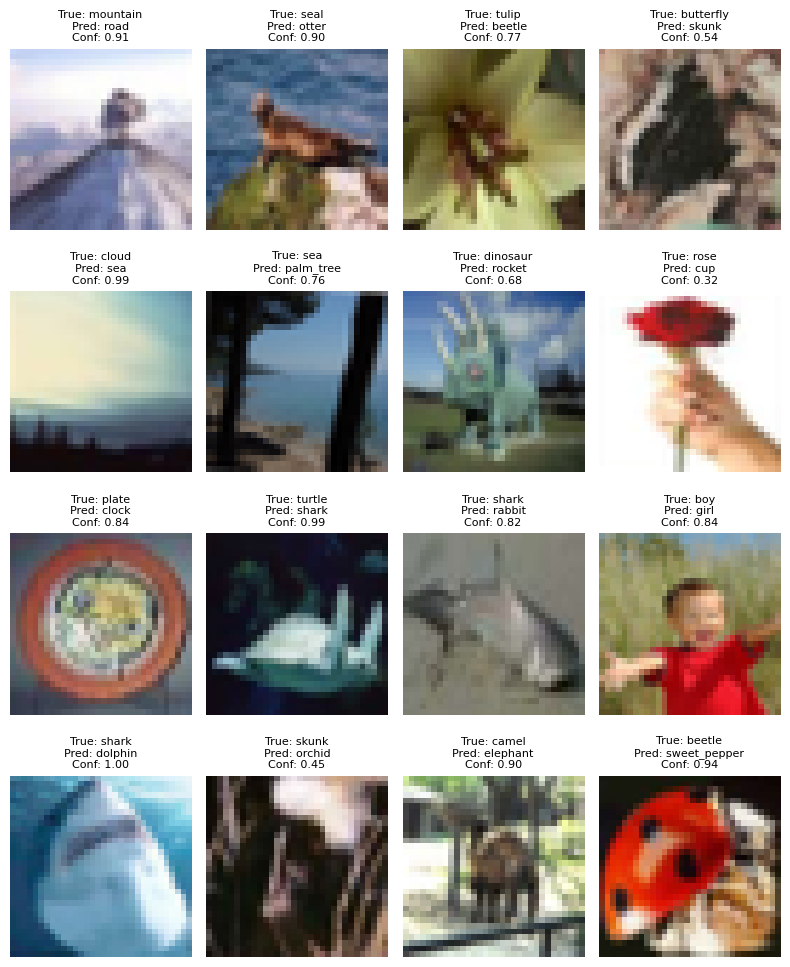

In [ ]:
class_names = train_ds.ds.classes
misclassified, worst_classes = analyze_misclassifications(model, device, test_loader, class_names, top_k=5)
show_misclassified(misclassified, class_names, n=16)